## Save activation values

In [131]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('donkeycar')
sys.path.append('src')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [132]:
import donkeycar as dk
cfg = dk.load_config(config_path='../mycar/config.py')

# None means all the data is used.
# use a smaller size, like 200 for testing end to end.
TUBRECORD_SIZE = None

cfg.SEQUENCE_LENGTH = 3
cfg.WANDB_ENABLED = False
cfg.TRANSFORMATIONS = ['CROP']
cfg.ROI_CROP_TOP = 60
cfg.ROI_CROP_KEEP_SIZE = False
N_FOLDS = None

model_type = '3d-modified-steering'

loading config file: ../mycar/config.py
loading personal config over-rides from myconfig.py


In [133]:
from dataloader import load_records

DATA_PATH = '../data/'

fast_data_path1 = 'faster-autodrive-18_20'
fast_data_path2 = 'fastest-autodrive-18_40'

fast_speed_data1 = load_records(fast_data_path1, cfg, DATA_PATH, TUBRECORD_SIZE)

fast_speed_data2 = load_records(fast_data_path2, cfg, DATA_PATH, TUBRECORD_SIZE)

fast_speed_data = fast_speed_data1

fast_speed_data.extend(fast_speed_data2)
len(fast_speed_data)

INFO:donkeycar.pipeline.types:Loading tubs from paths ['../data/faster-autodrive-18_20']


Using catalog /Users/kristjan.roosild/PycharmProjects/dat-sci-master-thesis/ood/../data/faster-autodrive-18_20/catalog_14.catalog


INFO:donkeycar.pipeline.types:Loading tubs from paths ['../data/fastest-autodrive-18_40']


Using catalog /Users/kristjan.roosild/PycharmProjects/dat-sci-master-thesis/ood/../data/fastest-autodrive-18_40/catalog_10.catalog


20771

In [110]:
# slow_data_path1 = 'daytime/daytime-manual-slower-1'
# slow_data_path2 = 'daytime/daytime-manual-slower-2'
# slow_speed_data1 = load_records(slow_data_path1, cfg, DATA_PATH, TUBRECORD_SIZE)
# slow_speed_data2 = load_records(slow_data_path2, cfg, DATA_PATH, TUBRECORD_SIZE)
# slow_speed_data = slow_speed_data1
# slow_speed_data.extend(slow_speed_data2)
# len(slow_speed_data)

INFO:donkeycar.pipeline.types:Loading tubs from paths ['../data/daytime/daytime-manual-slower-1']


Using catalog /Users/kristjan.roosild/PycharmProjects/dat-sci-master-thesis/ood/../data/daytime/daytime-manual-slower-1/catalog_10.catalog


INFO:donkeycar.pipeline.types:Loading tubs from paths ['../data/daytime/daytime-manual-slower-2']


Using catalog /Users/kristjan.roosild/PycharmProjects/dat-sci-master-thesis/ood/../data/daytime/daytime-manual-slower-2/catalog_21.catalog


31361

In [134]:
slow_data_path = 'daytime/daytime-manual-slower-2'
slow_speed_data = load_records(slow_data_path, cfg, DATA_PATH, TUBRECORD_SIZE)
len(slow_speed_data)

INFO:donkeycar.pipeline.types:Loading tubs from paths ['../data/daytime/daytime-manual-slower-2']


Using catalog /Users/kristjan.roosild/PycharmProjects/dat-sci-master-thesis/ood/../data/daytime/daytime-manual-slower-2/catalog_21.catalog


20642

In [135]:
from donkeycar.utils import get_model_by_type

fast_model_path = '../models/daytime/3d-steering-faster-daytime-full-data-multiply.h5'
fast_model = get_model_by_type(model_type, cfg)
fast_model.load(fast_model_path)
fast_model.interpreter.model.summary()

INFO:donkeycar.utils:get_model_by_type: model type is: 3d-modified-steering
INFO:donkeycar.parts.keras:input_shape (60, 160, 3) num_outputs 1
INFO:donkeycar.parts.keras:Created Keras3D_CNN_ModifiedOnlySteering with interpreter: KerasInterpreter
INFO:donkeycar.parts.keras:Num outputs 1
INFO:donkeycar.parts.keras:Sequence length 3
INFO:donkeycar.parts.keras:Loading model ../models/daytime/3d-steering-faster-daytime-full-data-multiply.h5
INFO:donkeycar.parts.interpreter:Loading model ../models/daytime/3d-steering-faster-daytime-full-data-multiply.h5


Model: "3dcnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img_in (InputLayer)          [(None, 3, 60, 160, 3)]   0         
_________________________________________________________________
conv3d (Conv3D)              (None, 1, 20, 53, 16)     1312      
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 1, 10, 26, 16)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 1, 10, 26, 32)     4640      
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 1, 5, 13, 32)      0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 1, 5, 13, 32)      9248      
_________________________________________________________________
flatten (Flatten)            (None, 2080)              0     

In [136]:
list(map(lambda x: x.name, fast_model.interpreter.model.layers))

['img_in',
 'conv3d',
 'max_pooling3d',
 'conv3d_1',
 'max_pooling3d_1',
 'conv3d_2',
 'flatten',
 'dense',
 'batch_normalization',
 'activation',
 'dropout',
 'dense_1',
 'batch_normalization_1',
 'activation_1',
 'dropout_1',
 'outputs']

In [137]:
from tensorflow import keras

fast_model_intermediate_layer = keras.Model(fast_model.interpreter.model.input,
                                            fast_model.interpreter.model.get_layer('dense_1').output)

In [138]:
import multiprocessing

from losses import get_pipe, get_dataset_from_pipe

In [139]:
pipe = get_pipe(fast_model, cfg, fast_speed_data)
data = get_dataset_from_pipe(pipe)
fast_model_fast_ai_data = fast_model_intermediate_layer.predict(
    data,
    workers=multiprocessing.cpu_count(),
    use_multiprocessing=True,
    steps=len(pipe),
    verbose=1)

163/163 [==============================] - 231s 1s/step


In [140]:
pipe = get_pipe(fast_model, cfg, slow_speed_data)
data = get_dataset_from_pipe(pipe)
fast_model_slow_manual_data = fast_model_intermediate_layer.predict(
    data,
    workers=multiprocessing.cpu_count(),
    use_multiprocessing=True,
    steps=len(pipe),
    verbose=1)

162/162 [==============================] - 227s 1s/step


In [141]:
slow_model_path = '../models/daytime/3d-steering-slower-daytime-full-data-multiply.h5'
slow_model = get_model_by_type(model_type, cfg)
slow_model.load(slow_model_path)
slow_model.interpreter.model.summary()

INFO:donkeycar.utils:get_model_by_type: model type is: 3d-modified-steering
INFO:donkeycar.parts.keras:input_shape (60, 160, 3) num_outputs 1
INFO:donkeycar.parts.keras:Created Keras3D_CNN_ModifiedOnlySteering with interpreter: KerasInterpreter
INFO:donkeycar.parts.keras:Num outputs 1
INFO:donkeycar.parts.keras:Sequence length 3
INFO:donkeycar.parts.keras:Loading model ../models/daytime/3d-steering-slower-daytime-full-data-multiply.h5
INFO:donkeycar.parts.interpreter:Loading model ../models/daytime/3d-steering-slower-daytime-full-data-multiply.h5


Model: "3dcnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img_in (InputLayer)          [(None, 3, 60, 160, 3)]   0         
_________________________________________________________________
conv3d (Conv3D)              (None, 1, 20, 53, 16)     1312      
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 1, 10, 26, 16)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 1, 10, 26, 32)     4640      
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 1, 5, 13, 32)      0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 1, 5, 13, 32)      9248      
_________________________________________________________________
flatten (Flatten)            (None, 2080)              0     

In [142]:
slow_model_intermediate_layer = keras.Model(slow_model.interpreter.model.input,
                                            slow_model.interpreter.model.get_layer('dense_1').output)

In [143]:
pipe = get_pipe(slow_model, cfg, fast_speed_data)
data = get_dataset_from_pipe(pipe)
slow_model_fast_ai_data = slow_model_intermediate_layer.predict(
    data,
    workers=multiprocessing.cpu_count(),
    use_multiprocessing=True,
    steps=len(pipe),
    verbose=1)

163/163 [==============================] - 39s 240ms/step


In [144]:
pipe = get_pipe(slow_model, cfg, slow_speed_data)
data = get_dataset_from_pipe(pipe)
slow_model_slow_manual_data = slow_model_intermediate_layer.predict(
    data,
    workers=multiprocessing.cpu_count(),
    use_multiprocessing=True,
    steps=len(pipe),
    verbose=1)

162/162 [==============================] - 36s 223ms/step


In [189]:
import numpy as np

np.savetxt("fast_model_fast_ai_data.csv.gz", np.float16(fast_model_fast_ai_data))
np.savetxt("fast_model_slow_manual_data.csv.gz", np.float16(fast_model_slow_manual_data))
np.savetxt("slow_model_fast_ai_data.csv.gz", np.float16(slow_model_fast_ai_data))
np.savetxt("slow_model_slow_manual_data.csv.gz", np.float16(slow_model_slow_manual_data))

# Analyze activation values

In [70]:
fast_model_fast_ai_data = np.loadtxt("fast_model_fast_ai_data.csv.gz")
fast_model_slow_manual_data = np.loadtxt("fast_model_slow_manual_data.csv.gz")
slow_model_fast_ai_data = np.loadtxt("slow_model_fast_ai_data.csv.gz")
slow_model_slow_manual_data = np.loadtxt("slow_model_slow_manual_data.csv.gz")

In [187]:
fast_model_fast_ai_data_unit_means = np.mean(fast_model_fast_ai_data, axis=0)
fast_model_slow_manual_data_unit_means = np.mean(fast_model_slow_manual_data, axis=0)
slow_model_fast_ai_data_unit_means = np.mean(slow_model_fast_ai_data, axis=0)
slow_model_slow_manual_data_unit_means = np.mean(slow_model_slow_manual_data, axis=0)
fast_model_fast_ai_data_unit_std = np.std(fast_model_fast_ai_data, axis=0)
fast_model_slow_manual_data_unit_std = np.std(fast_model_slow_manual_data, axis=0)
slow_model_fast_ai_data_unit_std = np.std(slow_model_fast_ai_data, axis=0)
slow_model_slow_manual_data_unit_std = np.std(slow_model_slow_manual_data, axis=0)

fast_model_fast_ai_data_unit_means.mean(), fast_model_slow_manual_data_unit_means.mean(), slow_model_fast_ai_data_unit_means.mean(), slow_model_slow_manual_data_unit_means.mean()

(-0.9916799286741931,
 -1.2808343707676366,
 -0.5273286111541168,
 -0.7571277410233062)

In [188]:
fast_model_fast_ai_data_unit_std.mean(), fast_model_slow_manual_data_unit_std.mean(), slow_model_fast_ai_data_unit_std.mean(), slow_model_slow_manual_data_unit_std.mean()

(1.04423291105631, 1.4598273887572417, 0.7397460932694455, 1.1036998633844315)

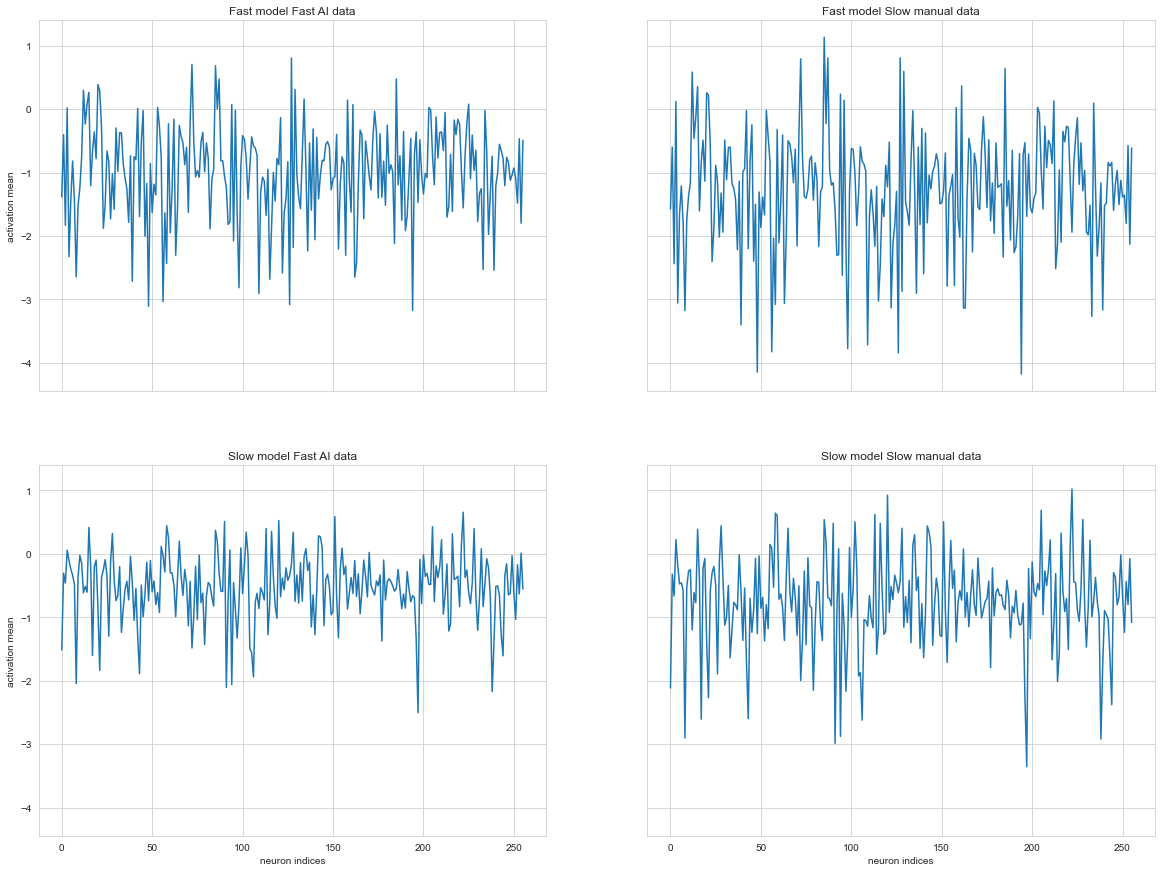

In [190]:
import matplotlib.pyplot as plt

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='all', sharey='all', figsize=(20, 15))
ax1.plot(fast_model_fast_ai_data_unit_means)
ax1.set_title('Fast model Fast AI data')
ax2.plot(fast_model_slow_manual_data_unit_means)
ax2.set_title('Fast model Slow manual data')
ax3.plot(slow_model_fast_ai_data_unit_means)
ax3.set_title('Slow model Fast AI data')
ax4.plot(slow_model_slow_manual_data_unit_means)
ax4.set_title('Slow model Slow manual data')

for ax in fig.get_axes():
    ax.set(xlabel='neuron indices', ylabel='activation mean')
    ax.label_outer()

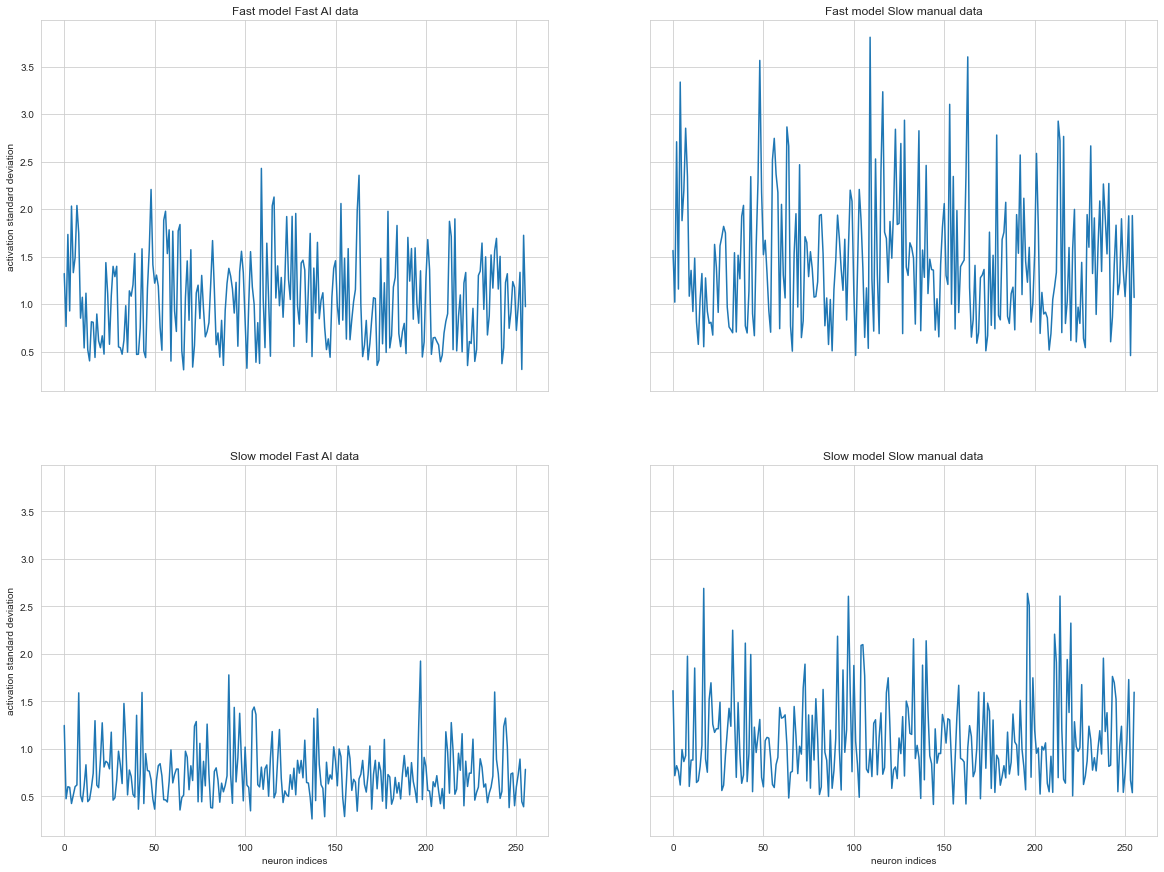

In [191]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='all', sharey='all', figsize=(20, 15))
ax1.plot(fast_model_fast_ai_data_unit_std)
ax1.set_title('Fast model Fast AI data')
ax2.plot(fast_model_slow_manual_data_unit_std)
ax2.set_title('Fast model Slow manual data')
ax3.plot(slow_model_fast_ai_data_unit_std)
ax3.set_title('Slow model Fast AI data')
ax4.plot(slow_model_slow_manual_data_unit_std)
ax4.set_title('Slow model Slow manual data')

for ax in fig.get_axes():
    ax.set(xlabel='neuron indices', ylabel='activation standard deviation')
    ax.label_outer()


## Use Manual fast data instead AI-collected fast data

In [178]:
fast_data_path = 'daytime/daytime-manual-faster'
fast_speed_data = load_records(fast_data_path, cfg, DATA_PATH, TUBRECORD_SIZE)
len(fast_speed_data)

INFO:donkeycar.pipeline.types:Loading tubs from paths ['../data/daytime/daytime-manual-faster']


Using catalog /Users/kristjan.roosild/PycharmProjects/dat-sci-master-thesis/ood/../data/daytime/daytime-manual-faster/catalog_25.catalog


24375

In [180]:
pipe = get_pipe(fast_model, cfg, fast_speed_data)
data = get_dataset_from_pipe(pipe)
fast_model_fast_manual_data = fast_model_intermediate_layer.predict(
    data,
    workers=multiprocessing.cpu_count(),
    use_multiprocessing=True,
    steps=len(pipe),
    verbose=1)

191/191 [==============================] - 46s 242ms/step


In [179]:
pipe = get_pipe(slow_model, cfg, fast_speed_data)
data = get_dataset_from_pipe(pipe)
slow_model_fast_manual_data = slow_model_intermediate_layer.predict(
    data,
    workers=multiprocessing.cpu_count(),
    use_multiprocessing=True,
    steps=len(pipe),
    verbose=1)

191/191 [==============================] - 243s 1s/step


In [181]:
fast_model_fast_manual_data_unit_means = np.mean(fast_model_fast_manual_data, axis=0)
fast_model_slow_manual_data_unit_means = np.mean(fast_model_slow_manual_data, axis=0)
slow_model_fast_manual_data_unit_means = np.mean(slow_model_fast_manual_data, axis=0)
slow_model_slow_manual_data_unit_means = np.mean(slow_model_slow_manual_data, axis=0)
fast_model_fast_manual_data_unit_std = np.std(fast_model_fast_manual_data, axis=0)
fast_model_slow_manual_data_unit_std = np.std(fast_model_slow_manual_data, axis=0)
slow_model_fast_manual_data_unit_std = np.std(slow_model_fast_manual_data, axis=0)
slow_model_slow_manual_data_unit_std = np.std(slow_model_slow_manual_data, axis=0)

fast_model_fast_manual_data_unit_means.mean(), fast_model_slow_manual_data_unit_means.mean(), slow_model_fast_manual_data_unit_means.mean(), slow_model_slow_manual_data_unit_means.mean()

(-1.2536261, -1.2808342, -0.7170885, -0.75712776)

In [193]:
fast_model_fast_manual_data_unit_std.mean(), fast_model_slow_manual_data_unit_std.mean(), slow_model_fast_manual_data_unit_std.mean(), slow_model_slow_manual_data_unit_std.mean()

(1.4288759, 1.4598273887572417, 1.0508025, 1.1036998633844315)

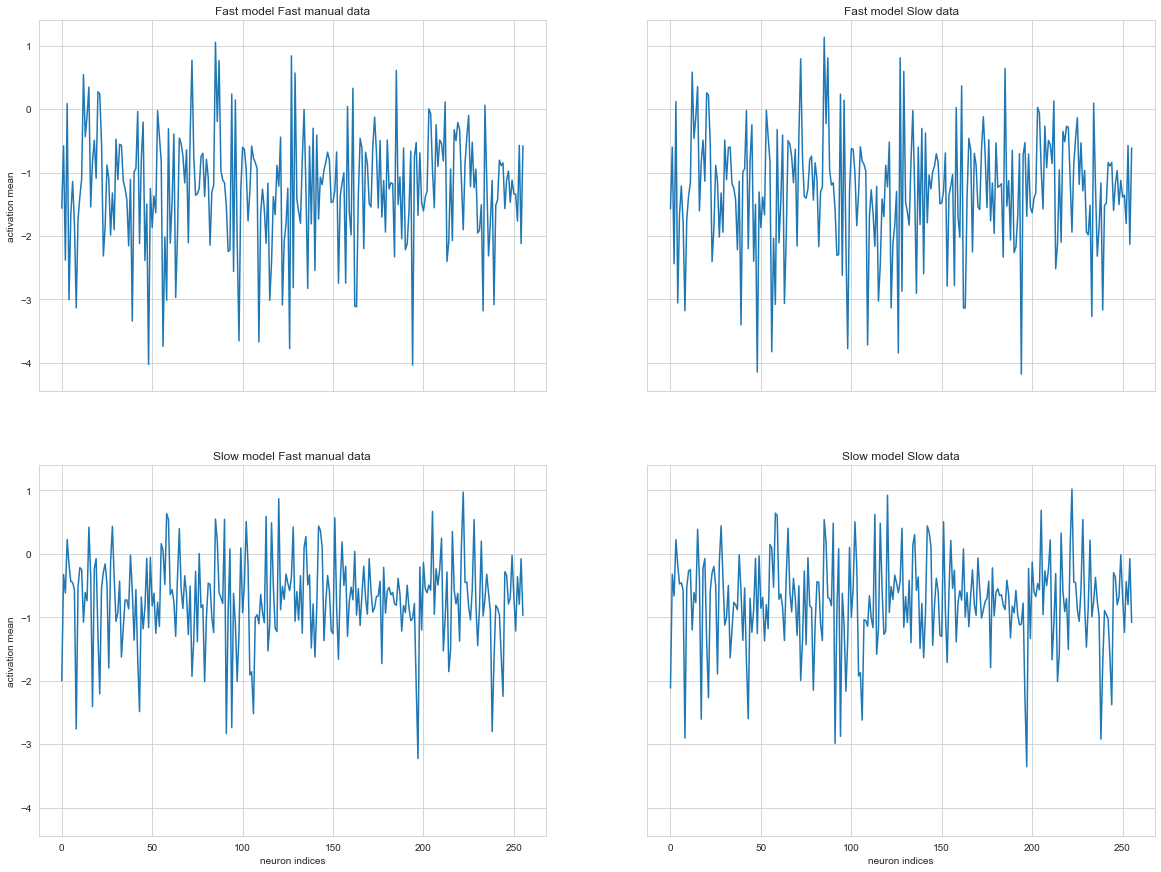

In [183]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='all', sharey='all', figsize=(20, 15))
ax1.plot(fast_model_fast_manual_data_unit_means)
ax1.set_title('Fast model Fast manual data')
ax2.plot(fast_model_slow_manual_data_unit_means)
ax2.set_title('Fast model Slow manual data')
ax3.plot(slow_model_fast_manual_data_unit_means)
ax3.set_title('Slow model Fast manual data')
ax4.plot(slow_model_slow_manual_data_unit_means)
ax4.set_title('Slow model Slow manual data')


for ax in fig.get_axes():
    ax.set(xlabel='neuron indices', ylabel='activation mean')
    ax.label_outer()

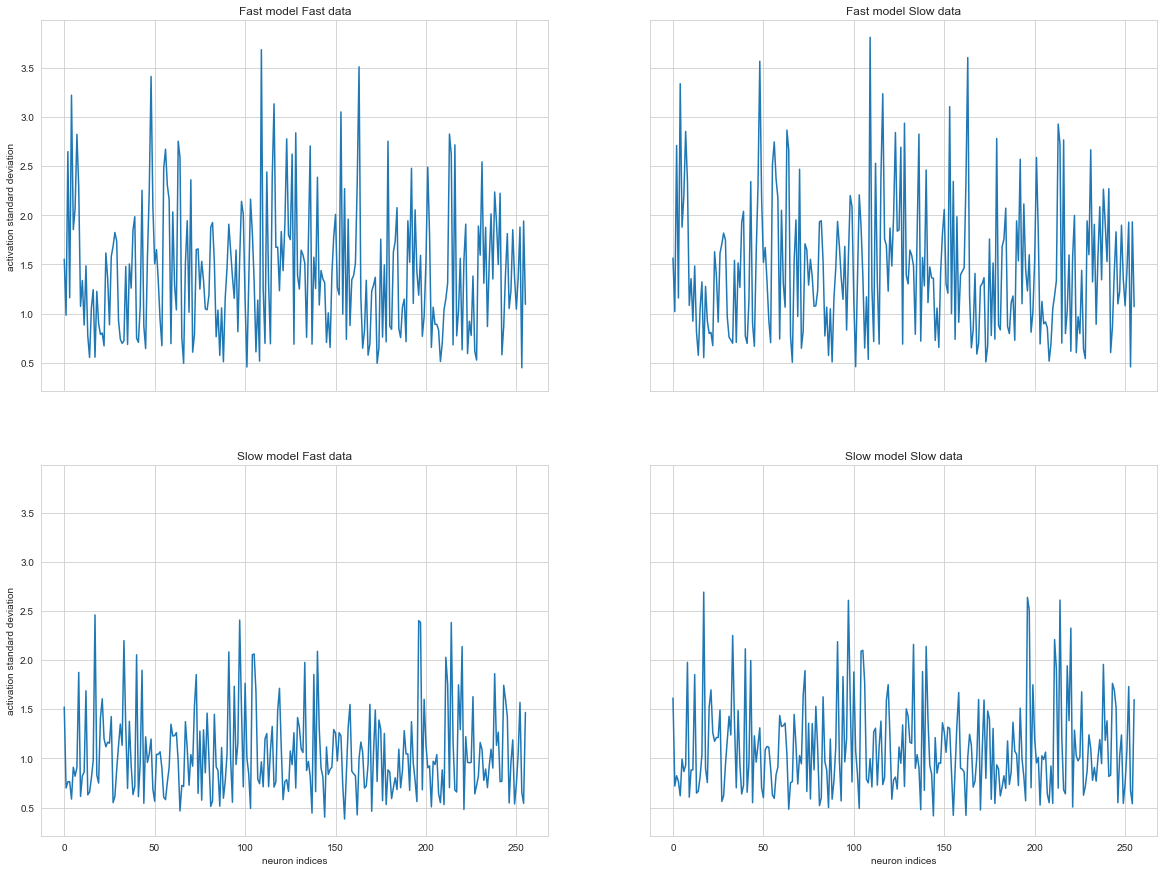

In [184]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='all', sharey='all', figsize=(20, 15))
ax1.plot(fast_model_fast_manual_data_unit_std)
ax1.set_title('Fast model Fast manual data')
ax2.plot(fast_model_slow_manual_data_unit_std)
ax2.set_title('Fast model Slow manual data')
ax3.plot(slow_model_fast_manual_data_unit_std)
ax3.set_title('Slow model Fast manual data')
ax4.plot(slow_model_slow_manual_data_unit_std)
ax4.set_title('Slow model Slow manual data')

for ax in fig.get_axes():
    ax.set(xlabel='neuron indices', ylabel='activation standard deviation')
    ax.label_outer()
